In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [43]:
df = pd.read_csv("/kaggle/input/bbc-full-text-document-classification/bbc_data.csv")
df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [44]:
df.isnull().sum()

data      0
labels    0
dtype: int64

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [46]:
df['labels'].value_counts()

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

# Preprocess

In [47]:
stop_words = stopwords.words('english')

def data_cleaning(text):

    # Convert to lower
    text = text.lower()
    
    remove_stopwords = [word for word in text.split() if word not in stop_words]
    text = ' '.join(remove_stopwords)
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r"\d", '', text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    
    return text
    

In [48]:
df['data_cleaned'] = df['data'].apply(data_cleaning)

# CountVectorizer & ANN

In [49]:
X = df['data_cleaned']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [50]:
vect = CountVectorizer()
vect.fit(df['data_cleaned'])

X_train = vect.transform(X_train).toarray()
X_test = vect.transform(X_test).toarray()

In [51]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [52]:
y_train[:2]

,business,entertainment,politics,sport,tech
1288,0,0,0,1,0
273,0,1,0,0,0


In [53]:
def initialize_model(input):
    input = tf.keras.Input(shape=(input,))

    x = Dense(32, activation='relu')(input)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)
    model = tf.keras.Model(input, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

CountVectorizer_ANN = initialize_model(X_train.shape[1])

In [54]:
history = CountVectorizer_ANN.fit(X_train, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5321 - loss: 1.2146 - val_accuracy: 0.9803 - val_loss: 0.3139
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9536 - loss: 0.2725 - val_accuracy: 0.9888 - val_loss: 0.1414
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9718 - loss: 0.1374 - val_accuracy: 0.9831 - val_loss: 0.1000
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9845 - loss: 0.0819 - val_accuracy: 0.9860 - val_loss: 0.0801
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9959 - loss: 0.0597 - val_accuracy: 0.9860 - val_loss: 0.0683
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9919 - loss: 0.0513 - val_accuracy: 0.9860 - val_loss: 0.0613
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9936 - loss: 0.0403 - val_accuracy: 0.9860 - val_loss: 0.0591
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9978 - loss: 0.0304 - val_accuracy: 0.9831 - v

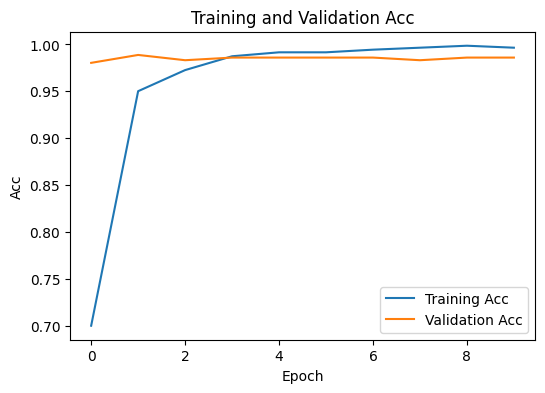

In [55]:
def plot_training_accuracy(history):
    plt.figure(figsize=(6, 4))

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(len(train_acc))

    plt.plot(epochs, train_acc, label="Training Acc")
    plt.plot(epochs, val_acc, label="Validation Acc")

    plt.title("Training and Validation Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()
    
plot_training_accuracy(history)

In [56]:
pred = CountVectorizer_ANN.predict(X_test)
pred[:1]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([[3.0317449e-04, 3.0281011e-04, 9.9811345e-01, 7.8686315e-04,
        4.9370399e-04]], dtype=float32)

Select the class with the highest probability as the predicted outcome

In [57]:
y_pred = np.argmax(pred, axis=1)

# Convert y_test from one-hot encoded format like [0 0 1 0] to categorical labels by selecting the index with the highest value
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_pred, y_test))

0.9685393258426966


Lets Examine the first 10 predicted and true test labels for evaluation

In [58]:
label_map = {0:'entertainment', 1:'business', 2:'sport', 3:'politics', 4:'tech'}

# Map ndarray elements to labels
pred_labels = [label_map[val] for val in y_pred[:10]]
true_labels = [label_map[val] for val in y_test[:10]]

print("pred_labels:", pred_labels)
print("true_labels:", true_labels)

pred_labels: ['sport', 'entertainment', 'tech', 'business', 'entertainment', 'business', 'sport', 'entertainment', 'politics', 'politics']
true_labels: ['sport', 'entertainment', 'tech', 'business', 'entertainment', 'business', 'sport', 'entertainment', 'politics', 'politics']


All first 10 samples are correctly classified.

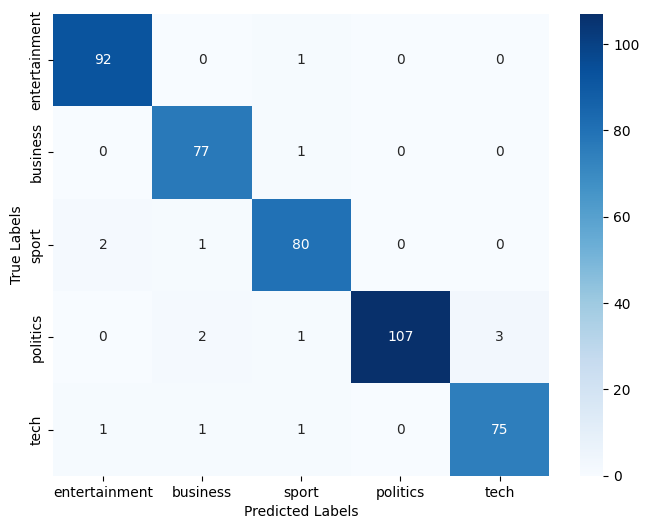

In [59]:
class_labels = ['entertainment', 'business','sport','politics','tech']

conf_matrix = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# TfidfVectorizer & ANN

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [61]:
tfid = TfidfVectorizer()

tfid.fit(X)

X_train = tfid.transform(X_train).toarray()
X_test = tfid.transform(X_test).toarray()

In [62]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [63]:
Tfidf_ANN = initialize_model(X_train.shape[1])

history = Tfidf_ANN.fit(X_train, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5675 - loss: 1.5670 - val_accuracy: 0.9719 - val_loss: 1.3693
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9236 - loss: 1.2624 - val_accuracy: 0.9831 - val_loss: 1.0474
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9521 - loss: 0.9055 - val_accuracy: 0.9831 - val_loss: 0.7486
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9679 - loss: 0.6207 - val_accuracy: 0.9803 - val_loss: 0.5370
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9797 - loss: 0.4294 - val_accuracy: 0.9831 - val_loss: 0.4017
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9874 - loss: 0.3033 - val_accuracy: 0.9831 - val_loss: 0.3164
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9842 - loss: 0.2400 - val_accuracy: 0.9831 - val_loss: 0.2588
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9856 - loss: 0.1938 - val_accuracy: 0.9860 - v

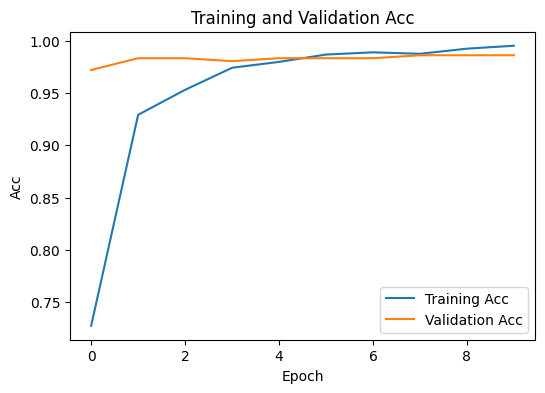

In [64]:
plot_training_accuracy(history)

In [65]:
pred = Tfidf_ANN.predict(X_test)

y_pred = np.argmax(pred, axis=1)

# Convert y_test from one-hot encoded format like [0 0 1 0] to categorical labels by selecting the index with the highest value
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_pred, y_test))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
0.9797752808988764
